## Automatic Extraction Method
Here the objective is to automatically extract rules from Instance Space Analysis metadata that can predict if an instance is hard or easy for a given classifier using that instances metafeatures.

Generate metadata, algorithm_bin and beta_easy for train, test and validation data

In [19]:
import preprocess as pp

# Directory with the CSV File with data for original features
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/compas"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/compas_no_race"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/covid/internacao"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/credit-g"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/glass"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/iris"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/pima_diabetes"
direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/cifar/people"
#direc = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/cifar/vehicles"

In [2]:
# Generate metadata, algorithm_bin and beta_easy for train and test data
pp.create_isa_datasets(direc)

100%|██████████| 20/20 [00:13<00:00,  1.45trial/s, best loss: -0.9316363636363637]
--- 881.3828377723694 seconds ---


Read .csv files with original data, metadata, algorithm_bin and beta_easy and extract rules from train data

In [8]:
import pandas as pd

train_idx = pd.read_csv(f'{direc}/train_idx.csv')
val_idx = pd.read_csv(f'{direc}/val_idx.csv')

train_idx.rename(columns={'0': 'idx'}, inplace=True)
val_idx.rename(columns={'0': 'idx'}, inplace=True)

df_train = pd.read_csv(f'{direc}/train.csv')
df_val = pd.read_csv(f'{direc}/val.csv')

df_metadata_train = pd.read_csv(f'{direc}/metadata_train.csv')
df_metadata_val = pd.read_csv(f'{direc}/metadata_val.csv')

df_algorithm_bin_train = pd.read_csv(f'{direc}/algorithm_bin_train.csv')
df_algorithm_bin_val = pd.read_csv(f'{direc}/algorithm_bin_val.csv')

df_beta_easy_train = pd.read_csv(f'{direc}/beta_easy_train.csv')
df_beta_easy_val = pd.read_csv(f'{direc}/beta_easy_val.csv')

#remove algorithms from metafeature sets
algos = ['algo_bagging', 'algo_gradient_boosting', 'algo_logistic_regression', 
     'algo_mlp', 'algo_random_forest', 'algo_svc_linear', 'algo_svc_rbf']

for a in algos:
    del df_metadata_train[a]
    del df_metadata_val[a]

# join algorithm bin and beta easy for train and validation data
df_performance_train = df_algorithm_bin_train.assign(IsBetaEasy = df_beta_easy_train['IsBetaEasy'])
df_performance_val = df_algorithm_bin_val.assign(IsBetaEasy = df_beta_easy_val['IsBetaEasy'])

Let's tune the hyperparameters merge and drop:

In [9]:
import numpy as np
import autoextractionmethod as aem

import time
start_time = time.time()

start_merge = 0
stop_merge = 0.01
step_merge = 0.002

start_drop = 0
stop_drop = 0.25
step_drop = 0.05

merge_space = np.arange(start_merge, stop_merge, step_merge)
drop_space = np.arange(start_drop, stop_drop, step_drop)

df_f1 = aem.tune_hyper_params(merge_space, 
                                    drop_space, 
                                    df_train, 
                                    df_metadata_train, 
                                    df_performance_train,
                                    df_metadata_val, 
                                    df_performance_val, 
                                    direc)

print("--- %s seconds ---" % (time.time() - start_time))

percent merge: 0.000, percent drop: 0.00
percent merge: 0.000, percent drop: 0.05
percent merge: 0.000, percent drop: 0.10
percent merge: 0.000, percent drop: 0.15
percent merge: 0.000, percent drop: 0.20
percent merge: 0.002, percent drop: 0.00
percent merge: 0.002, percent drop: 0.05
percent merge: 0.002, percent drop: 0.10
percent merge: 0.002, percent drop: 0.15
percent merge: 0.002, percent drop: 0.20
percent merge: 0.004, percent drop: 0.00
percent merge: 0.004, percent drop: 0.05
percent merge: 0.004, percent drop: 0.10
percent merge: 0.004, percent drop: 0.15
percent merge: 0.004, percent drop: 0.20
percent merge: 0.006, percent drop: 0.00
percent merge: 0.006, percent drop: 0.05
percent merge: 0.006, percent drop: 0.10
percent merge: 0.006, percent drop: 0.15
percent merge: 0.006, percent drop: 0.20
percent merge: 0.008, percent drop: 0.00
percent merge: 0.008, percent drop: 0.05
percent merge: 0.008, percent drop: 0.10
percent merge: 0.008, percent drop: 0.15
percent merge: 0

Let's plot the f1 scores to see if the search space is giving good results

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

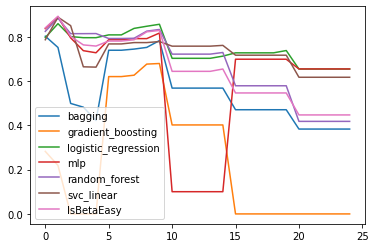

In [10]:
import matplotlib.pyplot as plt

plt.figure()

df_f1.plot()

Extract rules using the automatic extraction method

In [11]:
import autoextractionmethod as aem

import time
start_time = time.time()

df_best = pd.read_csv(f'{direc}/best_hyperparameters.csv')
df_best.rename(index={0: 'f1', 1:'merge', 2:'drop'}, inplace=True)

# extract the rule intervals using the train data
dict_E, dict_H = aem.auto_extraction(df_train, 
                                     df_metadata_train, 
                                     df_performance_train, 
                                     df_best.loc['drop'], 
                                     df_best.loc['merge'])

# Easy behavior rules
dict_easy_rules = aem.simple_rules(dict_E, len(df_train))

# Hard behavior rules
dict_hard_rules = aem.simple_rules(dict_H, len(df_train))

# Let's keep the metafeatures that are present in both easy and hard intervals for a given performance measure
# dict_easy_rules_common, dict_hard_rules_common = aem.common_rules(dict_easy_rules, 
#                                                                  dict_hard_rules)

# Let's predict the performance of the test datasets using the rules
# We also obtain the Positive Rule Disjunction (PRD) and Negative Rule Disjunction (NRD)  
# The disjunctive combination of all the simple positive rules or all the simple negative 
# rules is used to obtain a single positive and single negative rule.

dict_pred = aem.predict(df_performance_train, 
                        df_metadata_train, 
                        dict_easy_rules, 
                        dict_hard_rules)

print("--- %s seconds ---" % (time.time() - start_time))

--- 98.22257161140442 seconds ---


In [12]:
aem.display_side_by_side(dict_easy_rules["IsBetaEasy"] ,dict_hard_rules["IsBetaEasy"], titles=['Easy','Hard'])

# Latex tables
print(dict_easy_rules["IsBetaEasy"].drop(columns = 'Index').round(2).to_latex(index=False))  
print(dict_hard_rules["IsBetaEasy"].drop(columns = 'Index').round(2).to_latex(index=False))  


,Metafeature,Index,Interval,Support
0,feature_CL,"[621, 869]","[0.118588, 0.118588]",0.14
1,feature_DCP,"[458, 690]","[0.055263, 0.083612]",0.13
2,feature_LSC,"[0, 723]","[0.480962, 0.9499]",0.41
3,feature_N1,"[1366, 1467]","[0.0, 0.333333]",0.06
4,feature_N2,"[158, 416]","[0.388767, 0.434826]",0.15
5,feature_Usefulness,"[0, 487]","[0.338, 0.894]",0.28
6,feature_kDN,"[750, 1160]","[0.0, 0.0]",0.23
,Metafeature,Index,Interval,Support
0,feature_CL,"[1614, 1626]","[0.95582, 0.95735]",0.01
1,feature_LSC,"[1544, 1558]","[1.0, 1.0]",0.01


\begin{tabular}{llr}
\toprule
       Metafeature &             Interval &  Support \\
\midrule
        feature\_CL & [0.118588, 0.118588] &     0.14 \\
       feature\_DCP & [0.055263, 0.083612] &     0.13 \\
       feature\_LSC &   [0.480962, 0.9499] &     0.41 \\
        feature\_N1 &      [0.0, 0.333333] &     0.06 \\
        feature\_N2 & [0.388767, 0.434826] &     0.15 \\
feature\_Usefulness &       [0.338, 0.894] &     0.28 \\
       feature\_kDN &           [0.0, 0.0] &     0.23 \\
\bottomrule
\end{tabular}

\begin{tabular}{llr}
\toprule
Metafeature &           Interval &  Support \\
\midrule
 feature\_CL & [0.95582, 0.95735] &     0.01 \\
feature\_LSC &         [1.0, 1.0] &     0.01 \\
feature\_kDN &         [1.0, 1.0] &     0.01 \\
\bottomrule
\end{tabular}



This section is only done for CIFAR datasets

In [199]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import keras

#function to read files present in the Python version of the dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict
    
direc1 = "/home/camila/Documents/Faculdade/Projeto-Mestrado/Dados/Reais/cifar/cifar-100-python"

testData = unpickle(f'{direc1}/test')
trainData = unpickle(f'{direc1}/train')
metaData = unpickle(f'{direc1}/meta')

subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])

X_train = trainData['data']

data = []

for i in range(len(X_train)):
  nomeBatch = ''
  nomeBatch = (category.iloc[trainData['coarse_labels'][i]][0].capitalize())
  if (nomeBatch == "Vehicles_2"):
    data.append(i)

df = pd.DataFrame(data)

df.columns = ['id']

# saving the dataframe 
df.to_csv(f"{direc}/ids.csv") 

Using TensorFlow backend.


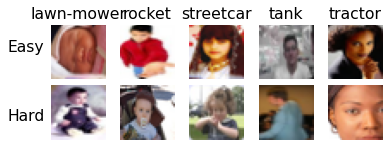

In [15]:
from matplotlib import pyplot
import preprocess as pp
from keras.datasets import cifar100

df_beta_class = df_beta_easy_test.assign(label = df_test['labels'])


#load ids
ids = pd.DataFrame(pd.read_csv(f"{direc}/ids.csv").id)

(trainX, trainy), (testX, testy) = cifar100.load_data()

# set the spacing between subplots
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.1)

direc_name = os.path.basename(direc)

#labels = ["baby", "boy", "girl", "man", "woman"]
labels = ["lawn-mower", "rocket", "streetcar", "tank", "tractor"]

# plot three hard images 
for i in range(5):
    index_easy = df_beta_class[(df_beta_class.IsBetaEasy == 1) & (df_beta_class.label == i)].index.to_list()
    index_hard = df_beta_class[(df_beta_class.IsBetaEasy == 0) & (df_beta_class.label == i)].index.to_list()

    # define subplot
    
    pyplot.subplot(2, 5, i+1).imshow(trainX[ids.iloc[test_idx.idx[index_easy[0]]][0]])
    plt.title(labels[i])
    plt.suptitle("Easy", x = 0.07, y = 0.65)
    plt.axis('off')
    pyplot.subplot(2, 5, i+6).imshow(trainX[ids.iloc[test_idx.idx[index_hard[0]]][0]])
    plt.axis('off')
    
plt.title("Hard", x = -5.5, y = 0.25)
plt.savefig(f'{direc}/Images/{direc_name}_images.pgf', pad_inches=0, bbox_inches = 'tight')
